#**DEEP DIVE PROJECT: Part-I/II**

Objective: Predict gas prices from historic data and other feature datasets.
Data selected, pruned and scored, baselines defined, feature importance established, shallow NN models explored 



---


---







---


## **SECTION- I:** Data Selection, Visualisation and Prepocessing

---



In [ ]:
import numpy as np
import datetime as dt
import pandas
import time
import random
import matplotlib
import pandas as pd
#%matplotlib notebook
import matplotlib.pyplot as plt
import scipy.stats
import matplotlib.offsetbox as offsetbox
from matplotlib.ticker import StrMethodFormatter

In [ ]:
params={
    "font.size":15,
    "lines.linewidth":5,
}
plt.rcParams.update(params)

In [ ]:
# Code snippet taken from class material
def getfile(gdrive,**kwargs): #tries to get local version and then defaults to google drive version
    loc = 'https://drive.google.com/uc?export=download&id='+gdrive.split('/')[-2]
    out=pandas.read_pickle(loc, **kwargs)
    return out

### Import the Features
Here we import the features saved as binary files in the project folder. We have identified that gasoline prices are primarily driven by classical economic theory of supply and demand. The supply of gasoline to the US is primarily from domestic crude oil wells and imports from other nations. The US also maintains a strategic petroleum reserve to handle the disruptions in the crude oil supply chain. Demand of gasoline is primarily reflected by domestic consumption. Other than these, inflation limits the purchasing power thus affecting both production/import and consumtion of gasoline. It is usually measured as Consumer Price Index (CPI) by the Federal Bank of the US. Further, changes in taxation at federal and state level will also impact the prices, however it remains constant over a long duration. Finally, we will also use historical trends in gasoline prices to capture any missing features. To summarize, we are building a Recurrent Neural Network (RNN) to predict the weekly gasoline price based on the following features:


1.   Weekly crude oil import (Supply)
2.   Strategic Petroleum Reserve (Supply)
3.   Domestic Production (Supply)
4.   Domestic Consumption of Gas (Demand)
5.   Domestic Inflation as CPI
6.   Historical Price of Gasoline

We first load the data from pickle files saved on the google drive folder.

In [ ]:
data = {}

# CPI
fname = "https://drive.google.com/file/d/1-CKtjFCPXvt1VHtMGhIZX3ew0yGD4kqA/view?usp=share_link"
data['CPI'] = getfile(fname)
data['CPI'] = data['CPI'].reset_index(drop=True)
data['CPI'] = data['CPI'].rename(columns={"Yearmon": "Date"})
data['CPI']['Date'] = data['CPI']['Date'].apply(lambda x: dt.datetime.strftime(x, '%Y-%d-%m'))
data['CPI']['Date'] = pandas.to_datetime(data['CPI']['Date'])
#print(data['CPI'].head())

# Consumption
fname = "https://drive.google.com/file/d/196YZI2degsMUuY2B_dGedX2dn7YqN8eA/view?usp=share_link"
data['Consumption'] = getfile(fname)
data['Consumption'] = data['Consumption'].rename(columns={"Week of": "Date"})
#print(data['Consumption'].head())

# Price
fname = "https://drive.google.com/file/d/1xZTHOvRw8dI2ZOQ2GQqa5TeEV9m7WLZ0/view?usp=share_link"
data['Price'] = getfile(fname)
#print(data['Price'].head())

# Imports
fname = "https://drive.google.com/file/d/10WJGO-BH3OLLMHHVtHHek4O-odPvsJyP/view?usp=share_link"
data['NetImports'] = getfile(fname)
#print(data['NetImports'].head())

# Reserve
fname = "https://drive.google.com/file/d/1TK9W9xA9tOH5qfjlmbh49L13Grj52u6f/view?usp=share_link"
data['Reserve'] = getfile(fname)[::-1]
data['Reserve'] = data['Reserve'].rename(columns={"Month": "Date"})
#print(data['Reserve'].head())

# Production
fname = "https://drive.google.com/file/d/12RZ5g-tlhVPQH5hMEgMoJOXFtXG_cL35/view?usp=share_link"
data['Production'] = getfile(fname)[::-1]
data['Production'] = data['Production'].rename(columns={"Month": "Date"})
#print(data['Production'].head())

We then truncate the data based on the available price data. We discard all of the data with an earlier date than the date of the first price data point.

In [ ]:
for feature in ['Production', 'CPI', 'NetImports', 'Reserve', 'Consumption']:
  data[feature] = data[feature].loc[data[feature].iloc[: , 0] > (data['Price'].iloc[0 , 0] - pandas.offsets.Day(12))].reset_index(drop=True)

Next, we match each price data-point with the feature data-points which have a date closest to the date of the price data-point. We note that we only consider feature data-points with an earlier date.

In [ ]:
data_list = []
for index, row in data['Price'].iterrows():
  for feature in ['Production', 'CPI', 'NetImports', 'Reserve', 'Consumption']:
    x = data[feature].loc[(data[feature]['Date'] < row['Date'])]
    row[feature] = x.loc[(x['Date'] - row['Date']).abs().idxmin()].iloc[1]

  data_list.append(row)

dataset = pandas.DataFrame(data_list)

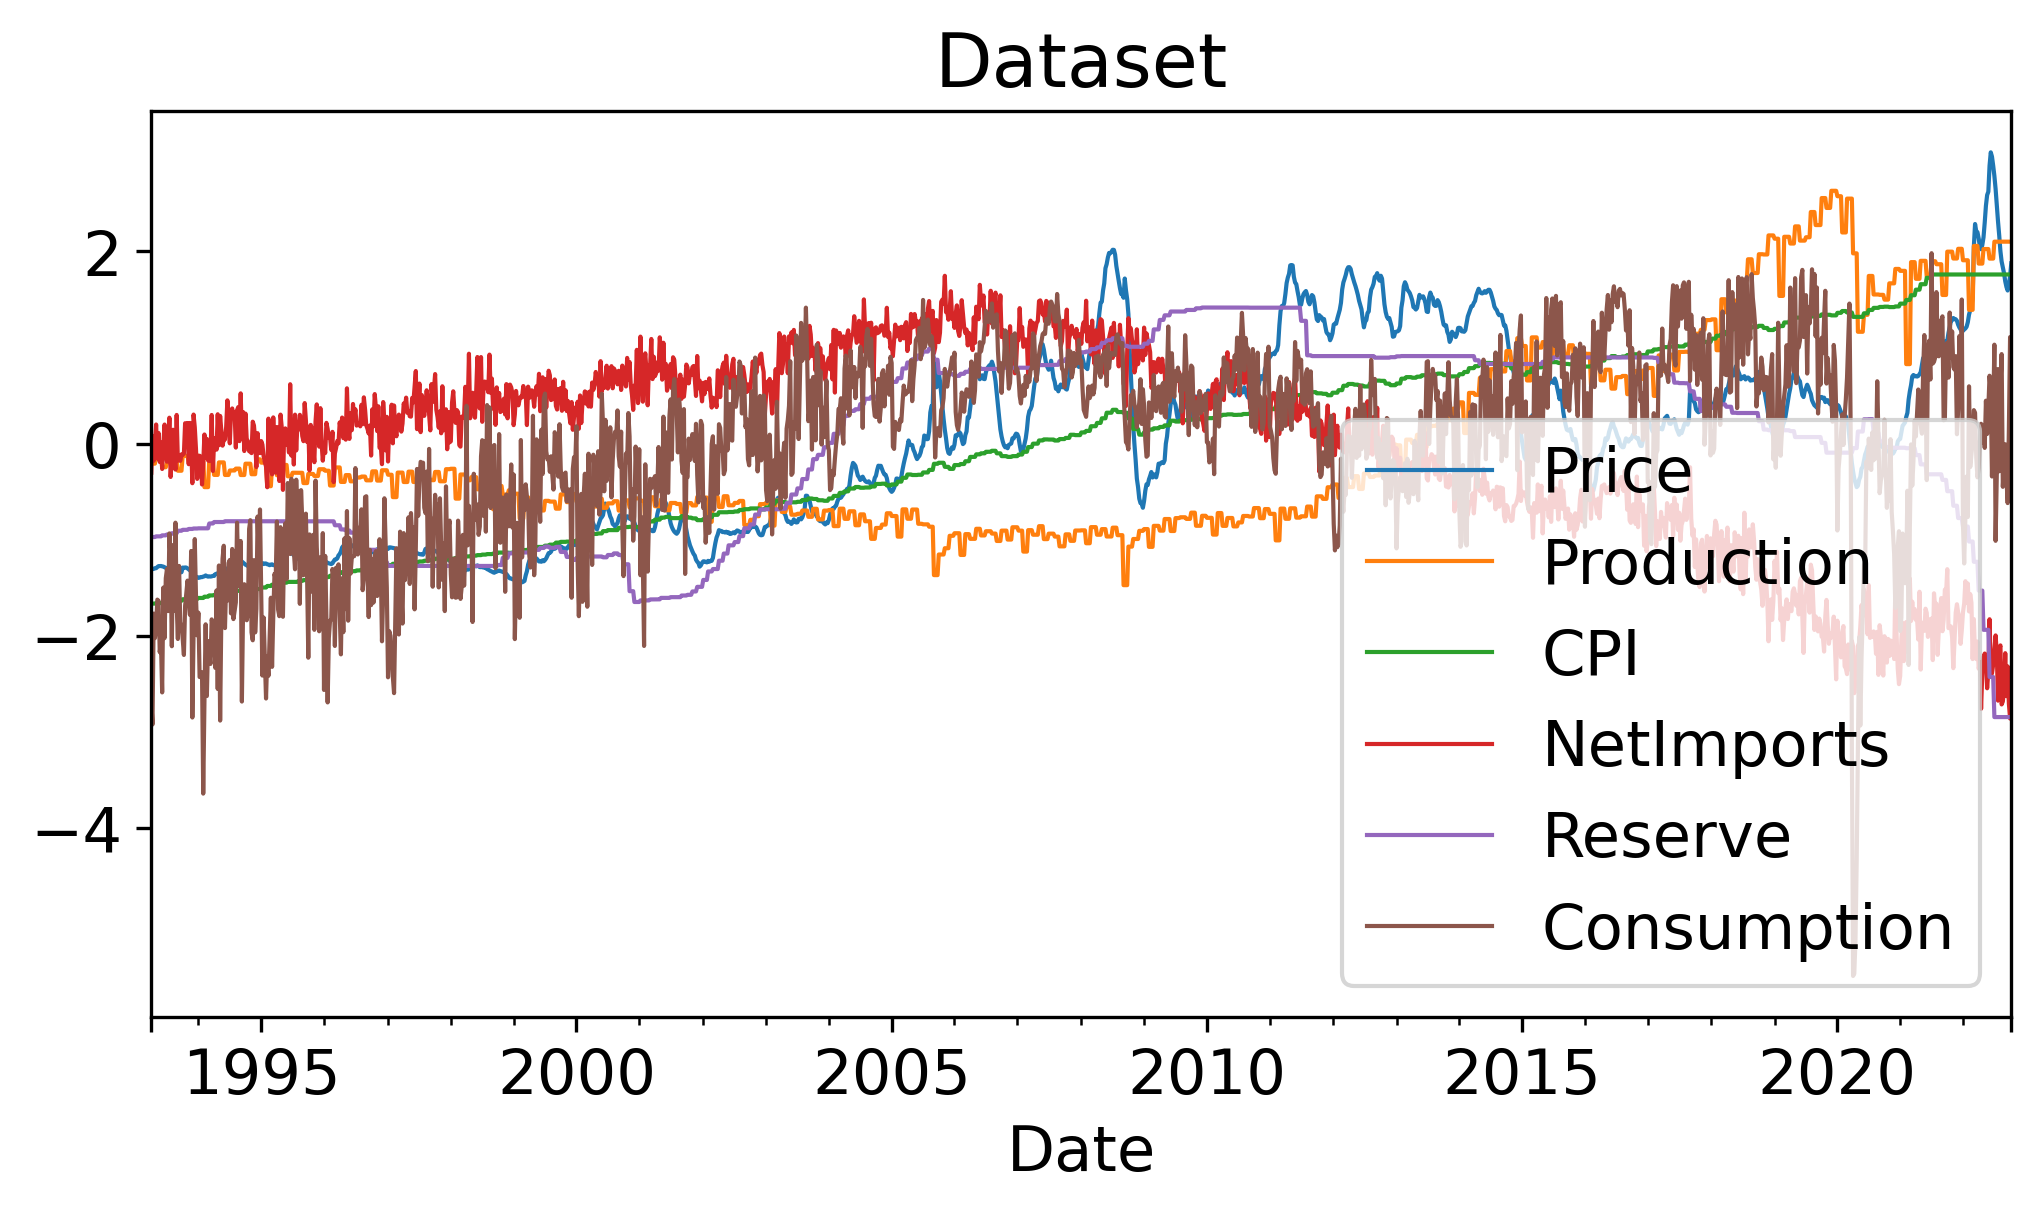

In [ ]:
#Visualizing data
#For plotting purposes we normalize everything. This normalization is not used as z-scored data
dataset_norm = dataset.copy()
dataset_norm.iloc[: , 1:] = (dataset_norm.iloc[: , 1:] - dataset_norm.iloc[: , 1:].mean()) / dataset_norm.iloc[: , 1:].std()
plt.figure(figsize=(8, 4), dpi=300)
plt.title('Dataset')
df = dataset_norm.plot(x='Date', linewidth=1, ax = plt.gca())


Before we extract any information from the data we split them into train, test and validation data. 

In [ ]:
#Importing libraries
import tensorflow as tf 
from sklearn.preprocessing import StandardScaler

#Splitting dataset to train, test and validate model
trainset = dataset[:-int(0.3 * len(dataset))].copy()
validationset = dataset[-int(0.3 * len(dataset)):-int(0.1 * len(dataset))].copy()
testset = dataset[-int(0.1 * len(dataset)):].copy()
trainset = trainset.drop(["Date"], axis = 1)
validationset = validationset.drop(["Date"], axis = 1)
testset = testset.drop(["Date"], axis = 1)
print("trainset length: "+ str(len(trainset))+ " | validationset length: " + str(len(validationset)) +  " | testset length: " + str(len(testset)) + " | Complete dataset length: " + str(len(dataset)))

#Z-scoring and normalizing feature set before model fitting 
names = dataset.columns[1:len(dataset)]
scaler = StandardScaler()
scaler = scaler.fit(trainset)
train_df = pd.DataFrame(scaler.transform(trainset))
train_df.columns = names

scaler = StandardScaler()
scaler = scaler.fit(testset)
test_df = pd.DataFrame(scaler.transform(testset))
test_df.columns = names

scaler = StandardScaler()
scaler = scaler.fit(validationset)
val_df = pd.DataFrame(scaler.transform(validationset))
val_df.columns = names

trainset length: 1079 | validationset length: 308 | testset length: 154 | Complete dataset length: 1541




---


## **SECTION-II:** Linear Regression Baseline

---



We use linear regression as a baseline model. First we train a linear regression model on the features which do not contain historic price data and then on the features containing the price of the previous week.


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn import svm

y_train = train_df.iloc[: , 1].to_numpy()
x_train = train_df.iloc[: , 2:].to_numpy()

y_val = val_df.iloc[: , 1].to_numpy()
x_val = val_df.iloc[: , 2:].to_numpy()

y_test = test_df.iloc[: , 1].to_numpy()
x_test = test_df.iloc[: , 2:].to_numpy()

reg = LinearRegression().fit(x_train, y_train)
y_train_hat = reg.predict(x_train)
y_val_hat = reg.predict(x_val)
y_test_hat = reg.predict(x_test)

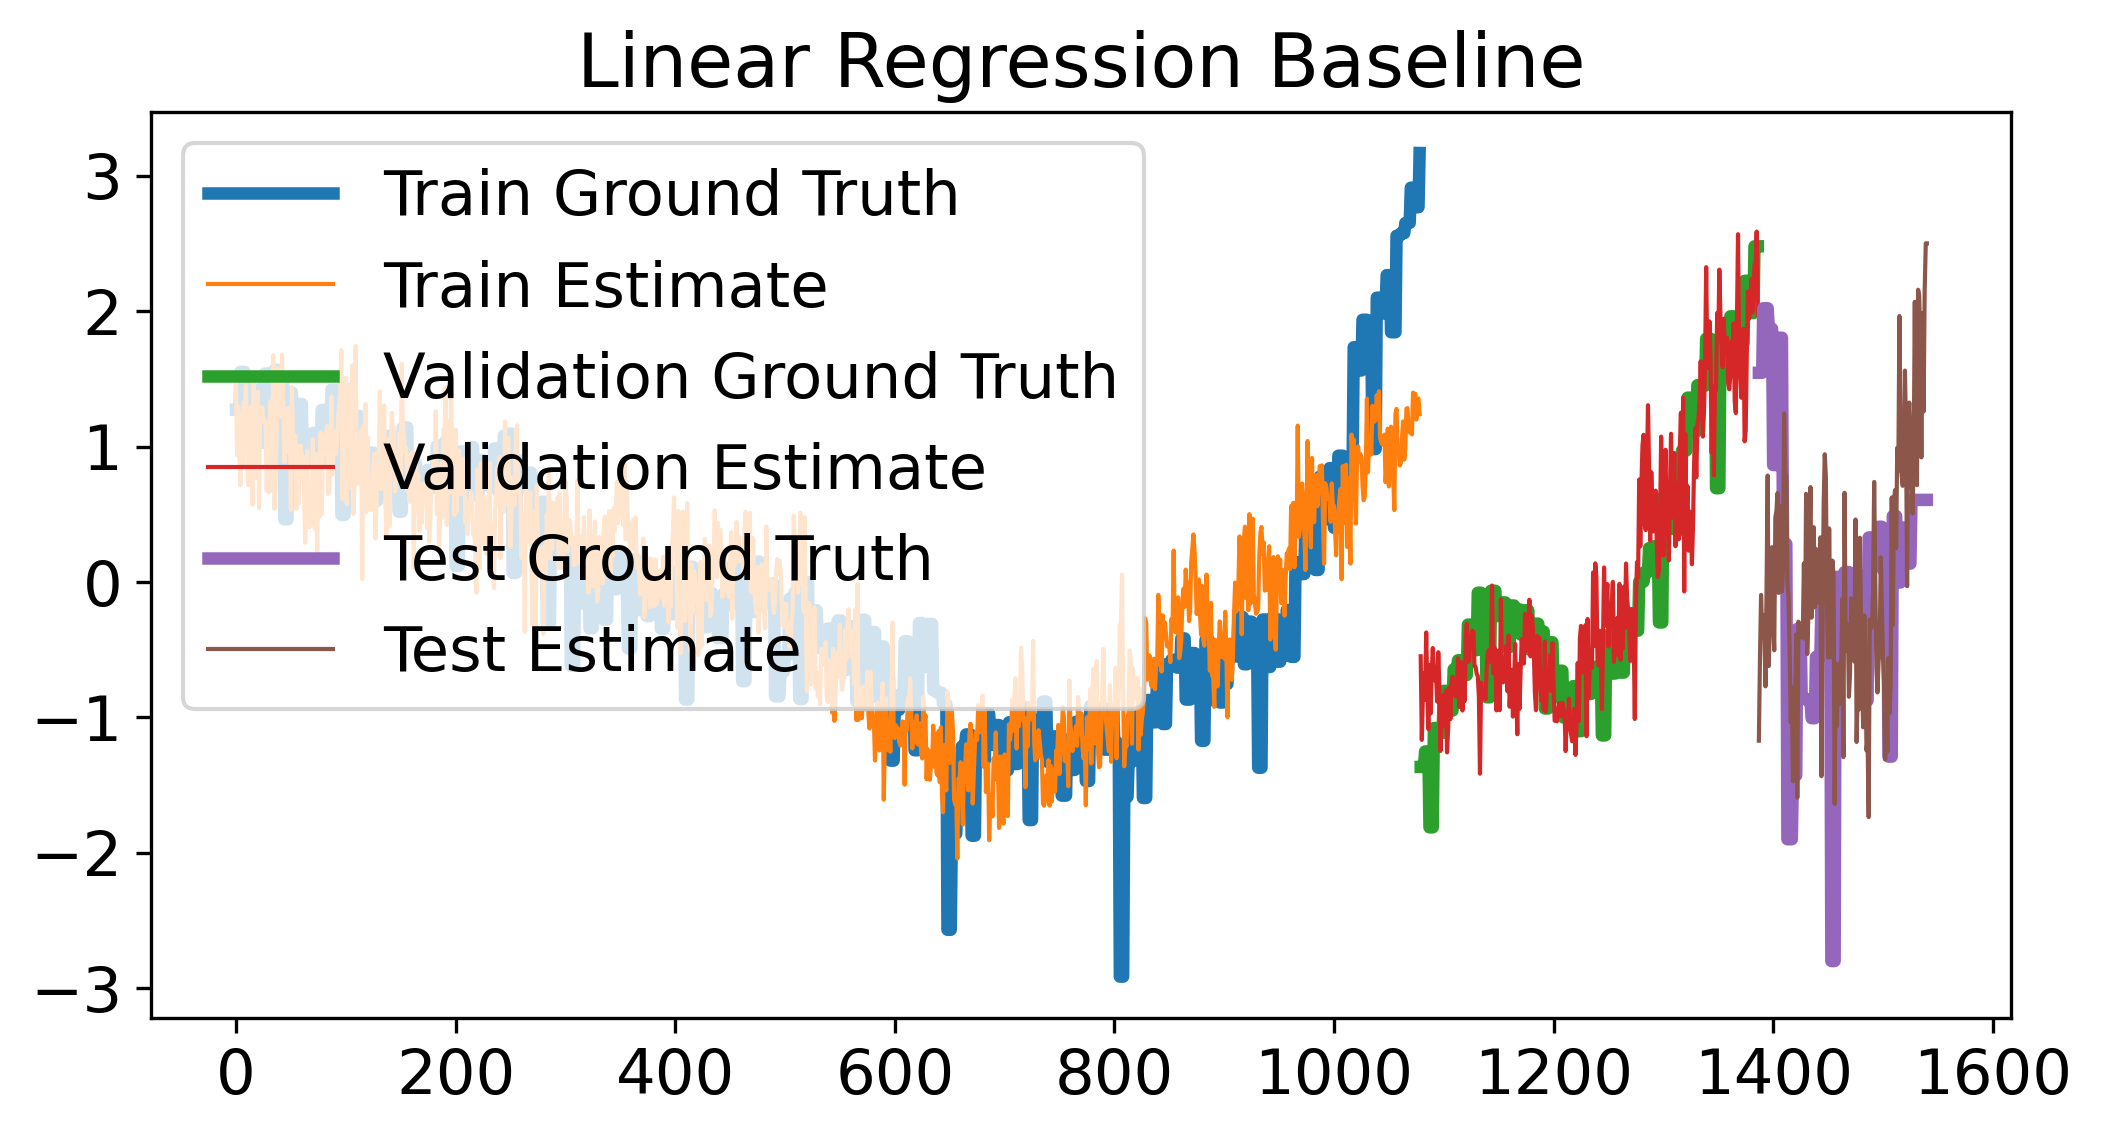

In [ ]:
plt.figure(figsize=(8, 4), dpi=300)
plt.plot(y_train, linewidth=3, label='Train Ground Truth')
plt.plot(y_train_hat, linewidth=1, label='Train Estimate')
plt.plot(np.arange(len(y_val))+len(y_train), y_val, linewidth=3, label='Validation Ground Truth')
plt.plot(np.arange(len(y_val))+len(y_train), y_val_hat, linewidth=1, label='Validation Estimate')
plt.plot(np.arange(len(y_test))+len(y_train)+len(y_val), y_test, linewidth=3, label='Test Ground Truth')
plt.plot(np.arange(len(y_test))+len(y_train)+len(y_val), y_test_hat, linewidth=1, label='Test Estimate')
plt.title('Linear Regression Baseline')
plt.legend()
plt.show()

Next we augment the features, by adding as a feature the price of the previous week. We observe that the performance is greatly improved all sets of data.

In [ ]:
train_df2 = pd.concat([train_df, train_df['Price'].shift(1)], axis=1, ignore_index=True)[1:]
y_train = train_df2.iloc[: , 1].to_numpy()
x_train = train_df2.iloc[: , 2:].to_numpy()

val_df2 = pd.concat([val_df, val_df['Price'].shift(1)], axis=1, ignore_index=True)[1:]
y_val = val_df2.iloc[: , 1].to_numpy()
x_val = val_df2.iloc[: , 2:].to_numpy()

test_df2 = pd.concat([test_df, test_df['Price'].shift(1)], axis=1, ignore_index=True)[1:]
y_test = test_df2.iloc[: , 1].to_numpy()
x_test = test_df2.iloc[: , 2:].to_numpy()

reg = LinearRegression().fit(x_train, y_train)
y_train_hat = reg.predict(x_train)
y_val_hat = reg.predict(x_val)
y_test_hat = reg.predict(x_test)

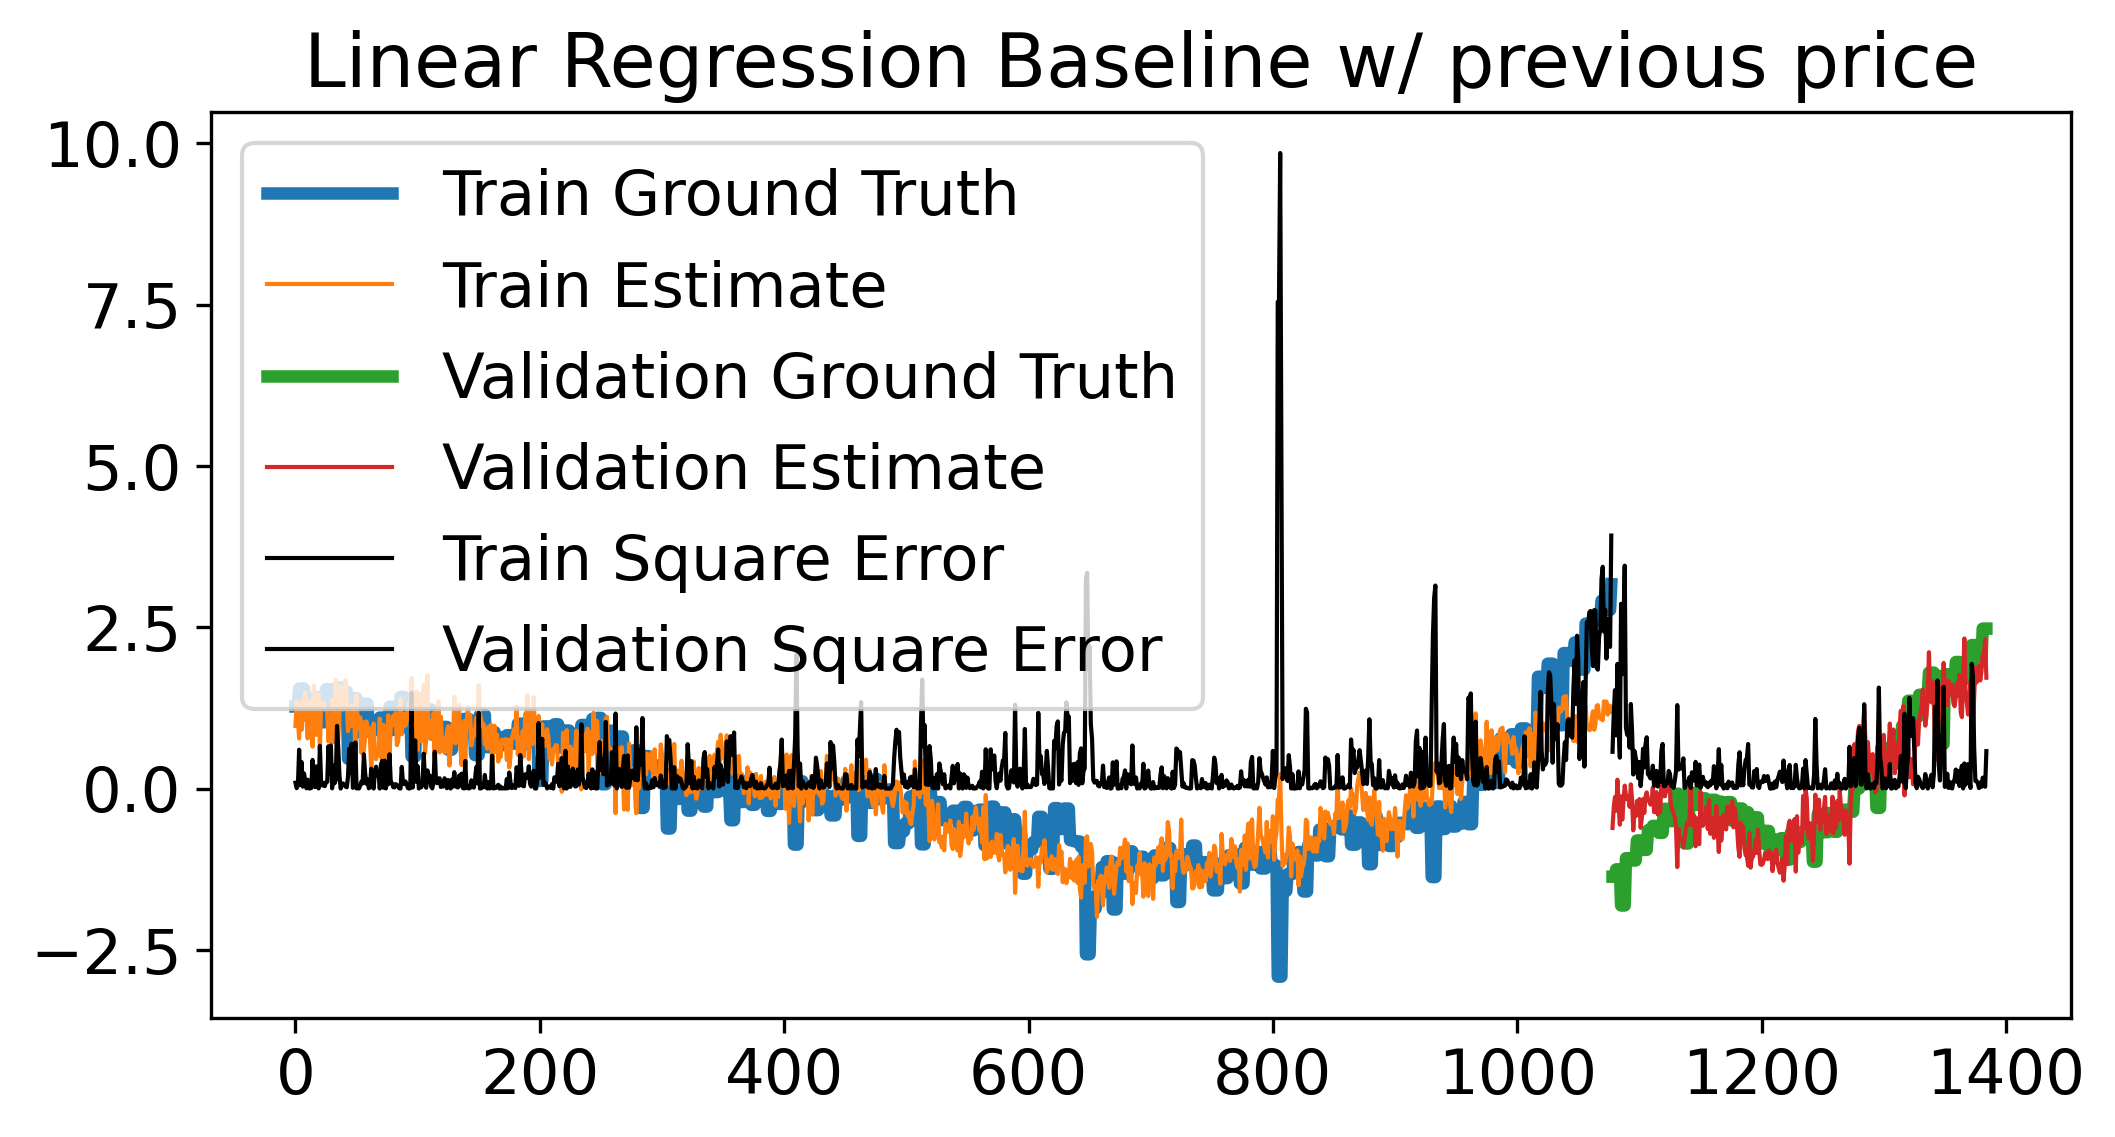

In [ ]:
plt.figure(figsize=(8,4), dpi=300)
plt.plot(y_train, linewidth=3, label='Train Ground Truth')
plt.plot(y_train_hat, linewidth=1, label='Train Estimate')
plt.plot(np.arange(len(y_val))+len(y_train), y_val, linewidth=3, label='Validation Ground Truth')
plt.plot(np.arange(len(y_val))+len(y_train), y_val_hat, linewidth=1, label='Validation Estimate')
plt.plot((y_train - y_train_hat)**2, color= 'black', linewidth=1, label='Train Square Error')
plt.plot(np.arange(len(y_val))+len(y_train), (y_val - y_val_hat)**2, color= 'black',linewidth=1, label='Validation Square Error')
plt.title('Linear Regression Baseline w/ previous price')
plt.legend()
plt.show()

The fact that the fitting improves substantially once historic data of the price itself is added as a feature shows the necessity of a long/short term memory of the price value



---


## **SECTION-III:** Feature Importance

---



First before we identify the heirarchy of features, we need to isolate the seasonality and trends in the features. Check for correlations between the features and then decide on appropriate analysis methods to identify feature importance 

###Initial test: Pearson Correlation Feature Importance 

Some of the chosen features have strong correlation. For example a simple Pearson correlation analysis shows that Net Imports and Production are 0.86 directly related. Here is the correlation matrix with the seasonality and trends intact and not separated from the data

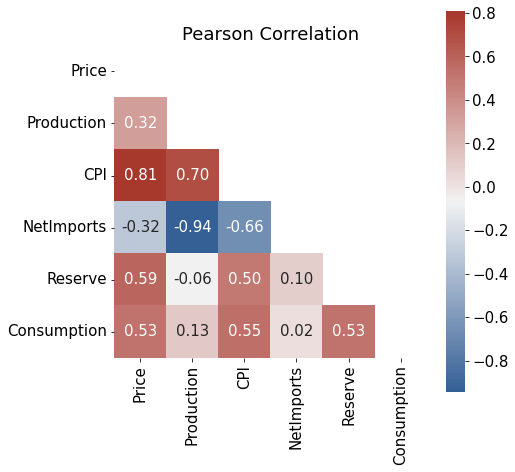

In [ ]:
import seaborn as sns

#Raw 'normalized' data correlated 
cmap = sns.diverging_palette(250, 15, s=75, l=40, n=9, center="light", as_cmap=True) 
matrix = dataset_norm.corr(method="pearson") # Compute correlation matrix
mask = np.triu(np.ones_like(matrix, dtype=bool))
fig, ax = plt.subplots(figsize=(7, 7))
sns.heatmap(matrix, mask=mask, cmap=cmap, square=True, annot=True, fmt=".2f", ax=ax)
plt.title('Pearson Correlation')
plt.show()


#### Seasonality
The feature data used has seasonality on two levels: monthly and annual. Currently annual seasonality is identified and removed from data to isolate trends

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc472a5c0a0>,
      dtype=object)

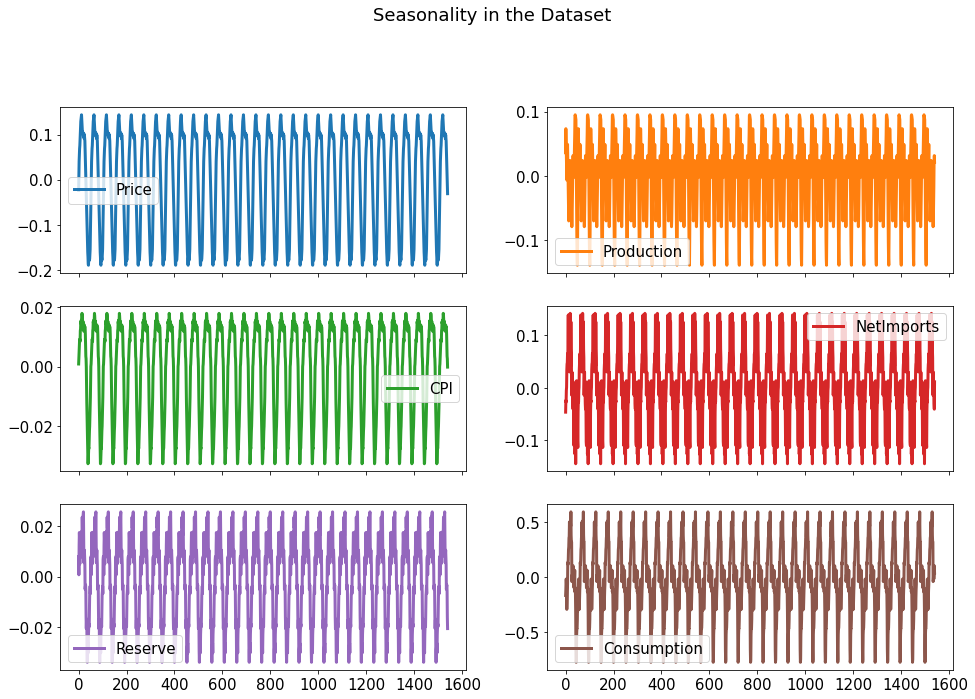

In [ ]:
import statsmodels.api as sm
import pandas as pd
from matplotlib import rcParams

seasonality_dict = {}
decompfreq = 52 #A year as our 'season'
for ts in range(1,len(dataset_norm.columns),1):
    decompositions = sm.tsa.seasonal_decompose(dataset_norm[dataset_norm.columns[ts]].dropna(), period=decompfreq)
    # Store the results back
    seasonality_dict[dataset_norm.columns[ts]] = decompositions.seasonal
# Plot seasonality
rcParams["figure.figsize"] = 16, 14
pd.DataFrame(seasonality_dict).plot(subplots=True, layout=(4, 2), linewidth=3, title = 'Seasonality in the Dataset')

Showing correlation in the seasonality of the features. Seeing how the periodicity between features/output variable match

/usr/local/lib/python3.8/dist-packages/seaborn/matrix.py:1214: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


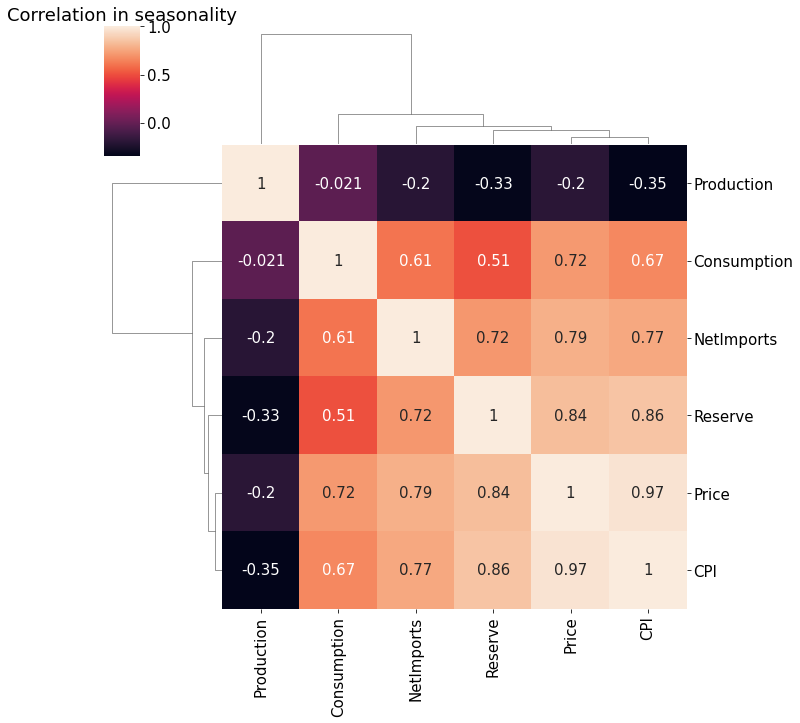

In [ ]:
#Correlation in seasonality
seasonality_dict = {dataset_norm.columns[ts]: sm.tsa.seasonal_decompose(dataset_norm[dataset_norm.columns[ts]].dropna(),period=decompfreq).seasonal for ts in range(1,len(dataset_norm.columns),1)}
seasonality_corr = pd.DataFrame(seasonality_dict).corr() # Compute corr matrix
sns.clustermap(seasonality_corr, annot=True, square=True)
plt.title('Correlation in seasonality', loc ='center')
plt.show()

#### Trends

 Devoid of seasonality in the dataset, the resulting trends are 'stationary' data

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc4726d2af0>,
      dtype=object)

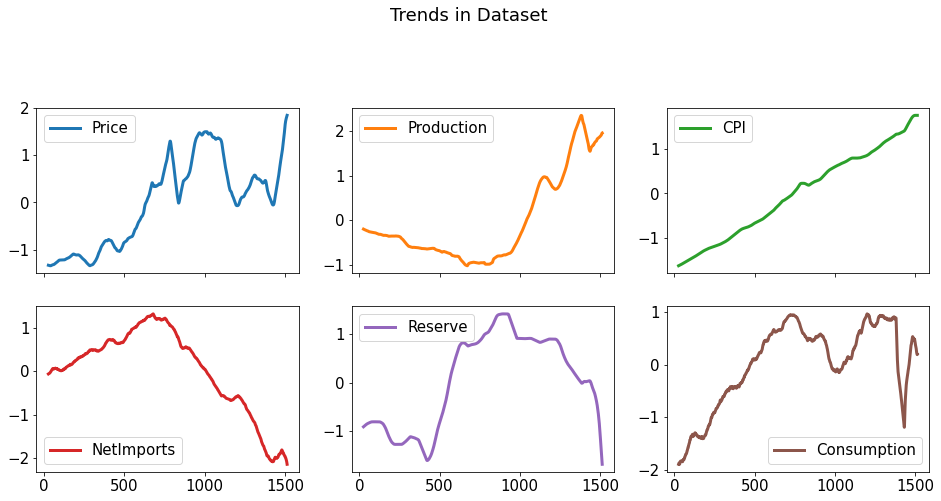

In [ ]:
N =4 #Smoothing trends over a month
trend_dict = {}
trend_dictoriginal= {}
for ts in range(1,len(dataset_norm.columns),1):
    decompositions = sm.tsa.seasonal_decompose(dataset_norm[dataset_norm.columns[ts]].dropna(),period=decompfreq)
    # Store back the results
    trend_dict[ts] = pd.Series(decompositions.trend).rolling(window=N).mean().iloc[N-1:]
    trend_dictoriginal[dataset_norm.columns[ts]]=decompositions.trend
#Plot Trends
pd.DataFrame(trend_dictoriginal).plot(subplots=True, layout=(4, 3), linewidth=3, title = 'Trends in Dataset')

/usr/local/lib/python3.8/dist-packages/seaborn/matrix.py:1214: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


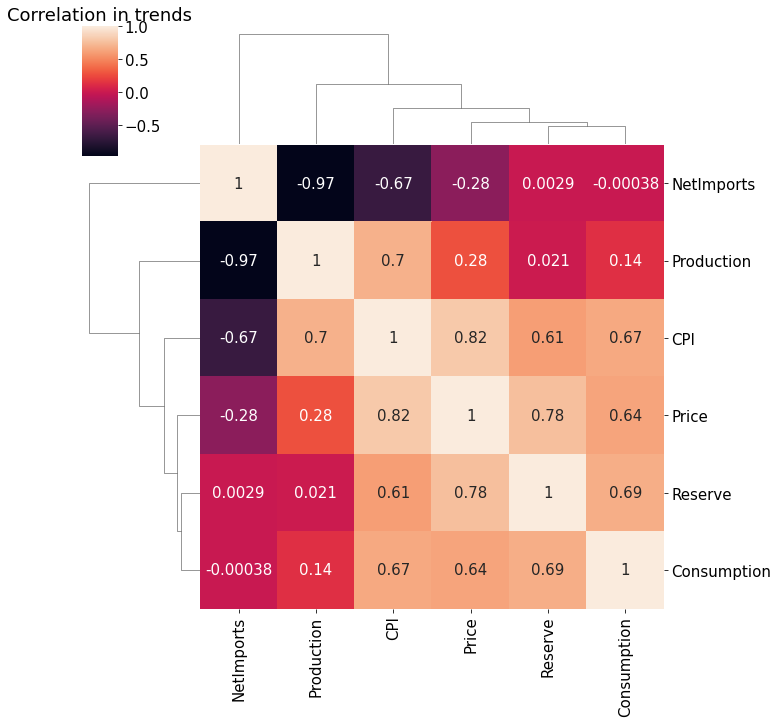

In [ ]:
#Correlation in trends
trend_dict = {dataset_norm.columns[ts]: pd.Series(sm.tsa.seasonal_decompose(dataset_norm[dataset_norm.columns[ts]].dropna(),period=decompfreq).trend).rolling(window=N).mean().iloc[N-1:] for ts in range(1,len(dataset_norm.columns),1)}
trend_dict = pd.DataFrame(trend_dict).corr()
sns.clustermap(trend_dict, annot=True, square=True)
plt.title('Correlation in trends')
plt.show()



---


**Key Takeaway:** 

*   'Price' is most correlated with 'CPI' (both seasonality and trend). It is even confirmed visually, as seen in the trend plots, the 'CPI' trace shows perturbations exactly when the 'Price' is perturbed across the entire range. 
*   Other features show strong correlation amongst each other.

*   Multiple feature importance models need to be explored since feature set has dependencies 



Based on Pearson correlation the feature importance is:

 **CPI > Reserve > Consumption**


---







### Additional Feature Importance Analysis

Since the feaures used are codependant as seen in Pearson correlation analysis we try a couple of different methods to identify feature importance 

####*Test-1 ANOVA statistical test*

In [ ]:
#Importing necessary libraries and modules
from numpy import set_printoptions
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

X_all = dataset_norm.loc[:, ["Production", "CPI", "NetImports", "Reserve", "Consumption"]]
Y_all = dataset_norm.loc[:,["Price"]]

test = SelectKBest(score_func = f_classif, k = 3) #K is number of features selected
fit1 = test.fit(X_all, Y_all.values.ravel())
set_printoptions(precision = 3)
features = fit1.transform(X_all)

ANOVA_features_for_training = test.fit_transform(X_all,Y_all.values.ravel())
ANOVA_support = test.get_support()
ANOVA_feature = X_all.loc[:,ANOVA_support].columns.tolist()

print('The ordered feature list based on importance is:', ANOVA_feature)


The ordered feature list based on importance is: ['CPI', 'Reserve', 'Consumption']


####*Test-2 Principal Component Analysis*

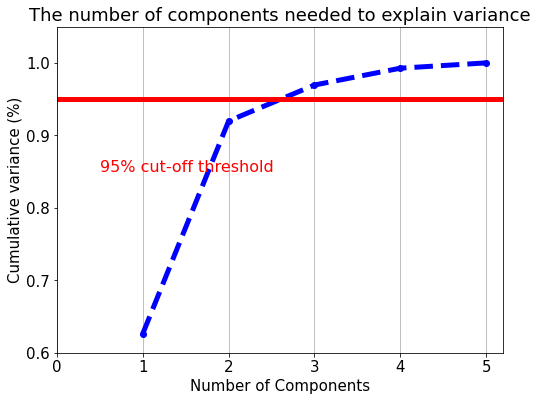

The model requires 3 components to successfully explain the variance in 'Price' (based on cut-off threshold chosen)
The features listed in order of importance:
CPI
Production
Reserve
CPI
NetImports


In [ ]:
from sklearn.decomposition import PCA
data_PCA = dataset_norm.loc[:, ["Production", "CPI", "NetImports", "Reserve", "Consumption"]]

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data_rescaled = scaler.fit_transform(data_PCA)

pca = PCA(n_components = 0.95)
pca.fit(data_rescaled)
reduced = pca.transform(data_rescaled)
pca = PCA().fit(data_rescaled)
pca = PCA().fit(data_rescaled)

import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (8,6)
fig, ax = plt.subplots()
y = np.cumsum(pca.explained_variance_ratio_)
xi = np.arange(1, len(y)+1, step=1)
plt.ylim(0.6,1.05)
plt.plot(xi, y, marker='o', linestyle='--', color='b')
plt.xlabel('Number of Components')
plt.xticks(np.arange(0, max(xi)+1, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')
plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)
ax.grid(axis='x')
plt.show()

print("The model requires 3 components to successfully explain the variance in 'Price' (based on cut-off threshold chosen)")
#print(data_PCA.columns)
#print(abs( pca.components_ ))
print('The features listed in order of importance:')
for row in np.array(pca.components_ ):
  print(data_PCA.columns[np.argmax(row)])

#### *Test-3 Recursive Feature Elimination (RFE)*
This analysis method seeks to remove codependant features and whittles the list of features to only independant features 

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest

model = LinearRegression()
rfe = RFE(model)

rfe_training = rfe.fit_transform(X_all,Y_all)
rfe_support = rfe.get_support()
rfe_feature = pd.DataFrame(X_all).loc[:,rfe_support].columns.to_list()

print('The independant features are: ', rfe_feature)

The independant features are:  ['Production', 'CPI']




---

**Key takeways:**

Since 'Production', 'NetImports', 'Reserve' and 'Consumption' have strong correlations as shown earlier, RFE analysis elininates them and deems 'Production' representative. 'CPI' is the most important (independent) feature.

Together they form 'orthogonal dimensions' which together can describe 'Price' output in a linear regression model


---





---


##SECTION-IV: Multi-time Predictive Model Building 
Objective: To test several models with simple architectures to predict multiple output values. In this section we aim to see which model is able to predict 8 weeks (2 months) of petrol price with lowest mean absolute error (MAE)

Since the dataset is comparitively sparse and the features are codependant, a simple model is best suited as it would avoid overfitting the training dataset. 
If the simple models fail, additional architecture will be explored (See Milestone_4_Part_II)

---



In [ ]:
#The Subsequent sub-sections require the only the z-scored dataframes
#Dictionary to collate performance discriptors of different models 

multi_val_performance = {}
multi_performance = {}

In [ ]:
#Window defined based on observing data at specific instances to see comparison between inputs, labels (ground truth) and shifts (predictions) 
#Window class from https://www.tensorflow.org/tutorials/structured_data/time_series 

class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df, batch_size=4,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df
    self.batch_size = batch_size

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

  def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
      labels = tf.stack(
          [labels[:, :, self.column_indices[name]] for name in self.label_columns],
          axis=-1)


    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

  def plot(self, model=None, plot_col='Price', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
      plt.subplot(max_n, 1, n+1)
      plt.ylabel(f'{plot_col} [normed]')
      plt.plot(self.input_indices, inputs[n, :, plot_col_index],
              label='Inputs', marker='.', zorder=-10)

      if self.label_columns:
        label_col_index = self.label_columns_indices.get(plot_col, None)
      else:
        label_col_index = plot_col_index

      if label_col_index is None:
        continue

      plt.scatter(self.label_indices, labels[n, :, label_col_index],
                  edgecolors='k', label='Labels', c='#2ca02c', s=64)
      if model is not None:
        predictions = model(inputs)
        if len(predictions.shape) == 2:
          predictions = tf.expand_dims(predictions, -1)
        plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                    marker='X', edgecolors='k', label='Predictions',
                    c='#ff7f0e', s=64)
        plt.plot(self.label_indices, (predictions[n, :, label_col_index]-labels[n, :, label_col_index])**2,
              label='Error')
      if n == 0:
        plt.legend()

    plt.xlabel('Time [weeks]')


  def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=self.batch_size,)

    ds = ds.map(self.split_window)

    return ds

  @property
  def train(self):
    return self.make_dataset(self.train_df)

  @property
  def val(self):
    return self.make_dataset(self.val_df)

  @property
  def test(self):
    return self.make_dataset(self.test_df)

  @property
  def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
      # No example batch was found, so get one from the `.train` dataset
      result = next(iter(self.test))
      # And cache it for next time
      self._example = result
    return result


In [ ]:
#Function to Compile and fit defined models

def compile_and_fit(model, window, patience=5, max_epochs=30, optimizer=tf.keras.optimizers.Adam()):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min',restore_best_weights=True,)
  model.compile(loss=tf.keras.losses.MeanSquaredError(),optimizer=optimizer,metrics=[tf.keras.metrics.MeanAbsoluteError()])
  history = model.fit(window.train, epochs=max_epochs,validation_data=window.val,callbacks=[early_stopping])
  return history

In [ ]:
#Mutiple model performance feature plotter 
#Needs a dictionary with the model features collated 

def performance_plotter (multi_performance_hp, multi_val_performance_hp, choice=0, width = 0.2):  
    x = np.arange(len(multi_performance_hp))
    metric_index = 1
    val_mae = [v[metric_index] for v in multi_val_performance_hp.values()]
    test_mae = [v[metric_index] for v in multi_performance_hp.values()]
    if choice == 1:
      plt.bar(x - 0.17, val_mae, width, label='Validation')
      plt.bar(x + 0.17, test_mae, width, label='Test')
      plt.xticks(ticks=x, labels=multi_performance_hp.keys(),rotation=90)
    else:
      plt.bar(x - 0.17, val_mae, width, label='Validation')
      plt.xlabel(f'Models tested')
    plt.ylabel(f'MAE (Mean Absolute Error)')
    _ = plt.legend()


####***Model-I Multi-variate Multi-time Long/Short Term Memory Flavored RNN (Optimized)***
An optimized RNN model is pursued as they are effective for time series data. Using Long/Short Term Memory specifically because the linear regression model with previous week's 'Price' as a feature was found to be effective


---



#####Model Definition
The model is built to be modular so that the hyperparameters can be tweaked 

In [ ]:
#Shallow LSTM model with single LSTM layer and a dense layer to provide prediction on expected number of output points

def modular_lstm_model(neuron=32,dropout_rate=0.1, activation_def = 'tanh', activation_rec = 'tanh', activation_dense = 'relu'):   
    model = tf.keras.Sequential([
      tf.keras.layers.LSTM(neuron, activation=activation_def, recurrent_activation=activation_rec, dropout = dropout_rate, return_sequences=False),
      tf.keras.layers.Dense(Output_steps*num_features, activation= activation_dense),
      tf.keras.layers.Reshape([Output_steps, num_features])
    ])
      
    return model

In [ ]:
#Typical window example
Output_steps = 8
Input_steps = 16  #The hyperparameter optimization arrives at this value
num_features = train_df.shape[1]

multi_window = WindowGenerator(input_width=Input_steps,
                               label_width=Output_steps,
                               shift=Output_steps)

In [ ]:
#Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:multi_window.total_window_size]),
                           np.array(train_df[200:200+multi_window.total_window_size]),
                           np.array(train_df[400:400+multi_window.total_window_size])])

example_inputs, example_labels = multi_window.split_window(example_window)

#####Hyperparameter Optimization (CAUTION: Do not run if time is a concern)
The activation functions and the number of input points contributing to the output are first optimized

In [ ]:
#CAUTION: Optimization step. Will take ~15mins
#Tracking performance through the cycling of hyperparameters in our quest to optimize 
multi_val_performance_hp = {}
multi_performance_hp = {}


activation1 = ['tanh','sigmoid']
activation_r = ['tanh','sigmoid','relu']
activation_d = ['tanh','sigmoid','relu']
Inputs = [int(Output_steps), int(Output_steps*2), int(Output_steps*3)]

activation_results = []

for act_1 in activation1:
  for act_r in activation_r:
    for act_d in activation_d:
      for Input_steps in Inputs:
        print('Training model')
        print('Input time steps: ' ,Input_steps, ' | Activation_1: ',act_1, ' | Activation_r: ',act_r, ' | Activation_d: ',act_d)
        lstm_model_x = modular_lstm_model(32,0.1,act_1,act_r,act_d)
        wide_window = WindowGenerator(input_width=Input_steps,label_width=Output_steps,shift=Output_steps)
        history = compile_and_fit(lstm_model_x, wide_window, max_epochs=30, patience=5, optimizer= tf.keras.optimizers.Adam())
        multi_val_performance_hp[str(act_1)+'|'+str(act_r)+'|'+str(act_d)+'|'+str(Input_steps)] = lstm_model_x.evaluate(wide_window.val)
        multi_performance_hp[str(act_1)+'|'+str(act_r)+'|'+str(act_d)+'|'+str(Input_steps)] = lstm_model_x.evaluate(wide_window.test, verbose=0)
        activation_results.append((Input_steps,act_1,act_r,act_d, min(history.history['val_mean_absolute_error'])))

Training model
Input time steps:  8  | Activation_1:  tanh  | Activation_r:  tanh  | Activation_d:  tanh
Epoch 1/30
266/266 [==============================] - 3s 6ms/step - loss: 0.3870 - mean_absolute_error: 0.4643 - val_loss: 0.8011 - val_mean_absolute_error: 0.7211
Epoch 2/30
266/266 [==============================] - 2s 8ms/step - loss: 0.1689 - mean_absolute_error: 0.2982 - val_loss: 0.7670 - val_mean_absolute_error: 0.6946
Epoch 3/30
266/266 [==============================] - 1s 5ms/step - loss: 0.1588 - mean_absolute_error: 0.2857 - val_loss: 0.7415 - val_mean_absolute_error: 0.6781
Epoch 4/30
266/266 [==============================] - 1s 5ms/step - loss: 0.1546 - mean_absolute_error: 0.2803 - val_loss: 0.7211 - val_mean_absolute_error: 0.6655
Epoch 5/30
266/266 [==============================] - 1s 4ms/step - loss: 0.1520 - mean_absolute_error: 0.2777 - val_loss: 0.7159 - val_mean_absolute_error: 0.6618
Epoch 6/30
266/266 [==============================] - 1s 5ms/step - loss: 0

Minima : 0.5603808164596558
Best number of input steps : 16 per 8 Output steps  | Best Activation1 function : tanh | Best Activation reverse function : sigmoid | Best Activation dense function : tanh


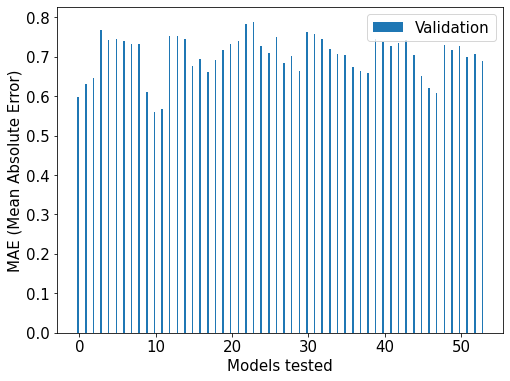

In [ ]:
#Plotting the hyperparameter optimization of deciding activation functions and number of historic values of input needed for predicting output points
performance_plotter (multi_performance_hp, multi_val_performance_hp, 0,width = 0.2)

activation_results2 = np.array(list(zip(*activation_results)))
min_val_loss = min(np.array(activation_results2[4]))
arrayIndex = activation_results2[4].tolist().index(min_val_loss)
print('Minima : '+str(min_val_loss))
print('Best number of input steps : '+str(activation_results2[:,arrayIndex][0]) + ' per ' + str(Output_steps) + ' Output steps '+ ' | Best Activation1 function : '+str(activation_results2[:,arrayIndex][1])+ ' | Best Activation reverse function : ' +str(activation_results2[:,arrayIndex][2])+ ' | Best Activation dense function : ' +str(activation_results2[:,arrayIndex][3]))


Epoch 1/30
264/264 [==============================] - 4s 9ms/step - loss: 0.3640 - mean_absolute_error: 0.4505 - val_loss: 0.8344 - val_mean_absolute_error: 0.7007
Epoch 2/30
264/264 [==============================] - 2s 7ms/step - loss: 0.1740 - mean_absolute_error: 0.3019 - val_loss: 0.8100 - val_mean_absolute_error: 0.6825
Epoch 3/30
264/264 [==============================] - 2s 7ms/step - loss: 0.1637 - mean_absolute_error: 0.2904 - val_loss: 0.7924 - val_mean_absolute_error: 0.6705
Epoch 4/30
264/264 [==============================] - 2s 7ms/step - loss: 0.1585 - mean_absolute_error: 0.2838 - val_loss: 0.7568 - val_mean_absolute_error: 0.6501
Epoch 5/30
264/264 [==============================] - 2s 7ms/step - loss: 0.1536 - mean_absolute_error: 0.2775 - val_loss: 0.7393 - val_mean_absolute_error: 0.6376
Epoch 6/30
264/264 [==============================] - 2s 7ms/step - loss: 0.1511 - mean_absolute_error: 0.2746 - val_loss: 0.7246 - val_mean_absolute_error: 0.6241
Epoch 7/30
264/2

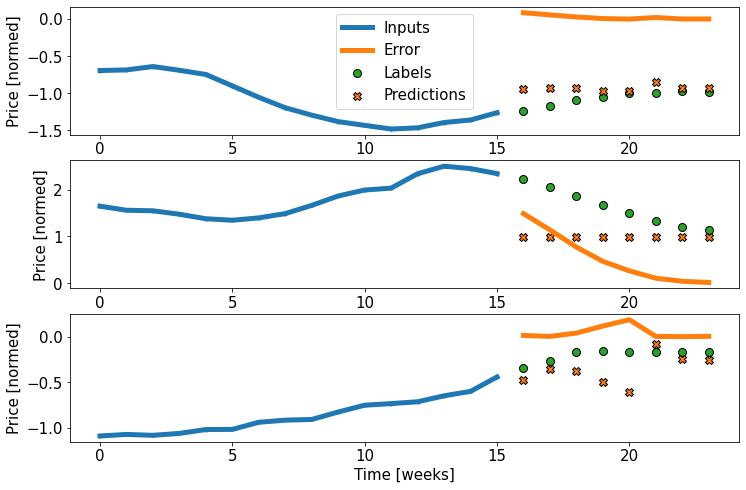

In [ ]:
#The codes have been commented out to save time as they would need the optimization runs to feed the values
#Instead the outputs have been manually added 

#Input = 16 points to predict 8 output points
#Activation functions: Best Activation1 function : tanh | Best Activation reverse function : sigmoid | Best Activation dense function : tanh

#Input_steps = int(activation_results2[:,arrayIndex][0])
Input_steps = 16
Output_steps = 8

num_features = train_df.shape[1]

multi_window = WindowGenerator(input_width=Input_steps,
                               label_width=Output_steps,
                               shift=Output_steps)

#best_lstm_model1 =  modular_lstm_model(32,0.1,str(activation_results2[:,arrayIndex][1]),str(activation_results2[:,arrayIndex][2]),str(activation_results2[:,arrayIndex][3]))
best_lstm_model1 =  modular_lstm_model(32,0.1,'tanh','sigmoid','tanh')
history = compile_and_fit(best_lstm_model1, multi_window, max_epochs=30, patience=5, optimizer= tf.keras.optimizers.Adam())
multi_val_performance['LSTM- Activation function optimized'] = best_lstm_model1.evaluate(multi_window.val)
multi_performance['LSTM- Activation function optimized'] = best_lstm_model1.evaluate(multi_window.test, verbose=0)
multi_window.plot(best_lstm_model1)


Now varying the number of epochs, number of neurons, dropout and optimizers to optimize the model

In [ ]:
#CAUTION: Optimization step. Will take ~30mins
#Tracking performance through the cycling of hyperparameters in our quest to optimize 
dropouts = [0.0,0.1]
epochs = [30,50]
number_of_neurons =[16,28,32]
optimizers = [0, 1] # 0 is Adam and 1 is Gradient Descent (SGD)

multi_val_performance_hp2 = {}
multi_performance_hp2 = {}
parameter_results = []

for neuron in number_of_neurons:
  for dropout in dropouts:
    for epoch in epochs:
      for opti in optimizers:
        print('Training model')
        print('Number of neurons: ' ,neuron, ' | Dropout value: ',dropout, ' | Max Epochs: ',epoch, ' | Optimizer: ',opti)
        lstm_model2 =  modular_lstm_model(neuron,dropout,activation_results2[:,arrayIndex][1],activation_results2[:,arrayIndex][2],activation_results2[:,arrayIndex][3])
        wide_window2 = WindowGenerator(input_width=int(activation_results2[:,arrayIndex][0]),label_width=Output_steps,shift=Output_steps)
        if opti == 1:
          history = compile_and_fit(lstm_model2, wide_window2, max_epochs=epoch, patience=5, optimizer= tf.keras.optimizers.Adam())
        else:
          history = compile_and_fit(lstm_model2, wide_window2, max_epochs=epoch, patience=5, optimizer= tf.keras.optimizers.SGD())
        multi_val_performance_hp2[str(act_1)+'|'+str(act_r)+'|'+str(act_d)+'|'+str(Input_steps)] = lstm_model_x.evaluate(wide_window.val)
        multi_performance_hp2[str(act_1)+'|'+str(act_r)+'|'+str(act_d)+'|'+str(Input_steps)] = lstm_model_x.evaluate(wide_window.test, verbose=0)
        parameter_results.append(( neuron, dropout, epoch, opti, min(history.history['val_mean_absolute_error'])))

Training model
Number of neurons:  16  | Dropout value:  0.0  | Max Epochs:  30  | Optimizer:  <keras.optimizers.optimizer_v2.adam.Adam object at 0x7fc46b207370>
Epoch 1/30
264/264 [==============================] - 4s 8ms/step - loss: 0.4956 - mean_absolute_error: 0.5515 - val_loss: 0.8036 - val_mean_absolute_error: 0.6994
Epoch 2/30
264/264 [==============================] - 2s 6ms/step - loss: 0.2044 - mean_absolute_error: 0.3358 - val_loss: 0.8019 - val_mean_absolute_error: 0.6904
Epoch 3/30
264/264 [==============================] - 2s 6ms/step - loss: 0.1785 - mean_absolute_error: 0.3090 - val_loss: 0.7937 - val_mean_absolute_error: 0.6841
Epoch 4/30
264/264 [==============================] - 2s 6ms/step - loss: 0.1686 - mean_absolute_error: 0.2969 - val_loss: 0.7733 - val_mean_absolute_error: 0.6713
Epoch 5/30
264/264 [==============================] - 2s 6ms/step - loss: 0.1626 - mean_absolute_error: 0.2891 - val_loss: 0.7560 - val_mean_absolute_error: 0.6596
Epoch 6/30
264/264

In [ ]:
#Deciding number of neuros in LSTM layer, ideal droput value, max Epoch and suitable optimizer to use
parameter_results2 = np.array(list(zip(*parameter_results)))
min_val_loss2 = min(np.array(parameter_results2[4]))
arrayIndex2 = parameter_results2[4].tolist().index(min_val_loss2)
print('Minima : '+str(min_val_loss2))
print('Optimum number of neurons : '+str(parameter_results2[:,arrayIndex][0])+ ' | Optimum dropout value : '+str(parameter_results2[:,arrayIndex][1])+ ' | Suggested max Epoch : ' +str(parameter_results2[:,arrayIndex][2])+ ' | Suggested Optimizer : ' +str(parameter_results2[:,arrayIndex][3]))


Minima : 0.5076823234558105
Optimum number of neurons : 28 | Optimum dropout value : 0.0 | Suggested max Epoch : 50 | Suggested Optimizer : <keras.optimizers.optimizer_v2.adam.Adam object at 0x7fc46b207370>




---
Optimized Hyperparameters in current shallow LSTM RNN:


*   Optimum number of neurons in LSTM layer: 28
*   Dropout: 0.0
*   Maximum Epochs: 50
*   Ideal number of Input: 16 points to predict 8 output 'Price' points
*   Best Activation functions: Activation1 function : tanh | Activation reverse function : sigmoid | Activation dense function : tanh
*   Best Optimizer: Adam


---






The optimized LSTM-RNN is as given below: 

Epoch 1/50
264/264 [==============================] - 4s 8ms/step - loss: 0.3915 - mean_absolute_error: 0.4728 - val_loss: 0.8317 - val_mean_absolute_error: 0.7170
Epoch 2/50
264/264 [==============================] - 2s 8ms/step - loss: 0.1784 - mean_absolute_error: 0.3074 - val_loss: 0.7990 - val_mean_absolute_error: 0.6947
Epoch 3/50
264/264 [==============================] - 2s 9ms/step - loss: 0.1657 - mean_absolute_error: 0.2931 - val_loss: 0.7906 - val_mean_absolute_error: 0.6873
Epoch 4/50
264/264 [==============================] - 2s 7ms/step - loss: 0.1593 - mean_absolute_error: 0.2851 - val_loss: 0.7625 - val_mean_absolute_error: 0.6695
Epoch 5/50
264/264 [==============================] - 3s 11ms/step - loss: 0.1558 - mean_absolute_error: 0.2798 - val_loss: 0.7347 - val_mean_absolute_error: 0.6535
Epoch 6/50
264/264 [==============================] - 2s 7ms/step - loss: 0.1522 - mean_absolute_error: 0.2744 - val_loss: 0.6976 - val_mean_absolute_error: 0.6329
Epoch 7/50
264/

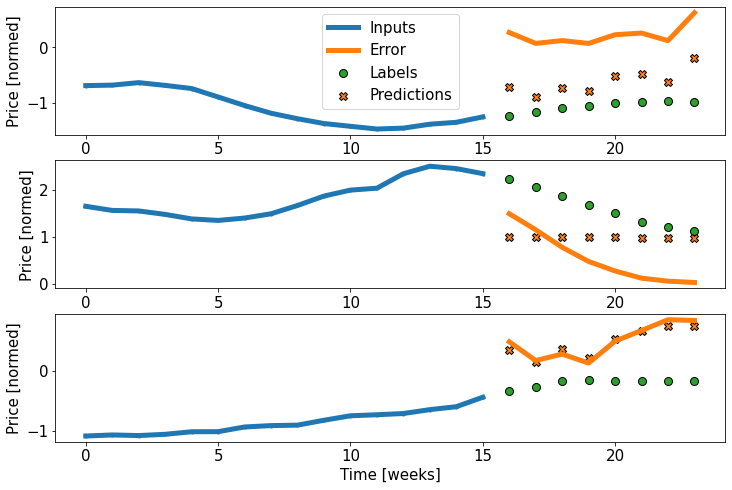

In [ ]:
#The codes have been commented out to save time as they would need the optimization runs to feed the values
#Instead the outputs have been manually added 

Output_steps = 8
#Input_steps = int(activation_results2[:,arrayIndex][0])
Input_steps = 20

num_features = train_df.shape[1]


#best_lstm_model2 =  modular_lstm_model(int(parameter_results2[:,arrayIndex][0]),int(parameter_results2[:,arrayIndex][1]),str(activation_results2[:,arrayIndex][1]),str(activation_results2[:,arrayIndex][2]),str(activation_results2[:,arrayIndex][3]))
best_lstm_model2 =  modular_lstm_model(28,0,'tanh','sigmoid','tanh')
#history = compile_and_fit(best_lstm_model2, multi_window, max_epochs=int(parameter_results2[:,arrayIndex][2]), patience=5, optimizer= tf.keras.optimizers.Adam())
history = compile_and_fit(best_lstm_model2, multi_window, max_epochs=50, patience=5, optimizer= tf.keras.optimizers.Adam())
multi_val_performance['LSTM-fully optimized'] = best_lstm_model2.evaluate(multi_window2.val)
multi_performance['LSTM-fully optimized'] = best_lstm_model2.evaluate(multi_window2.test, verbose=0)

multi_window.plot(best_lstm_model2)

####***Model-II LSTM-RNN (Unoptimized)***
An unoptimized RNN model to be a comparison point to the optimized model built earlier

---




Epoch 1/30
264/264 [==============================] - 4s 9ms/step - loss: 0.2931 - mean_absolute_error: 0.3917 - val_loss: 0.8478 - val_mean_absolute_error: 0.7265
Epoch 2/30
264/264 [==============================] - 2s 6ms/step - loss: 0.1171 - mean_absolute_error: 0.2422 - val_loss: 0.7083 - val_mean_absolute_error: 0.6535
Epoch 3/30
264/264 [==============================] - 2s 7ms/step - loss: 0.1011 - mean_absolute_error: 0.2205 - val_loss: 0.6478 - val_mean_absolute_error: 0.6147
Epoch 4/30
264/264 [==============================] - 2s 7ms/step - loss: 0.0931 - mean_absolute_error: 0.2081 - val_loss: 0.6045 - val_mean_absolute_error: 0.5871
Epoch 5/30
264/264 [==============================] - 2s 8ms/step - loss: 0.0883 - mean_absolute_error: 0.1999 - val_loss: 0.5778 - val_mean_absolute_error: 0.5701
Epoch 6/30
264/264 [==============================] - 2s 7ms/step - loss: 0.0844 - mean_absolute_error: 0.1939 - val_loss: 0.5522 - val_mean_absolute_error: 0.5570
Epoch 7/30
264/2

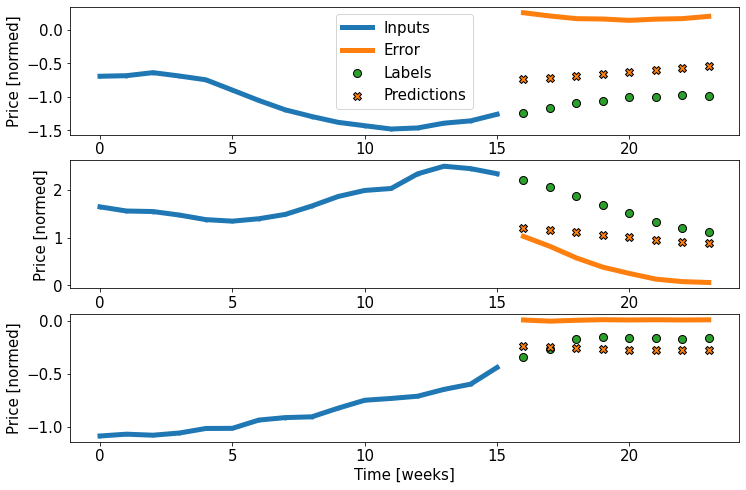

In [ ]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(Output_steps*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([Output_steps, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)


multi_val_performance['LSTM -Unoptimized'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM - Unoptimized'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

####***Model- III Multi-time step Last-Price Baseline Model***
Uses last value in the inpur historic 'Price' data and uses that as a 'baseline'


---



72/72 [==============================] - 0s 1ms/step - loss: 0.2589 - mean_absolute_error: 0.3052


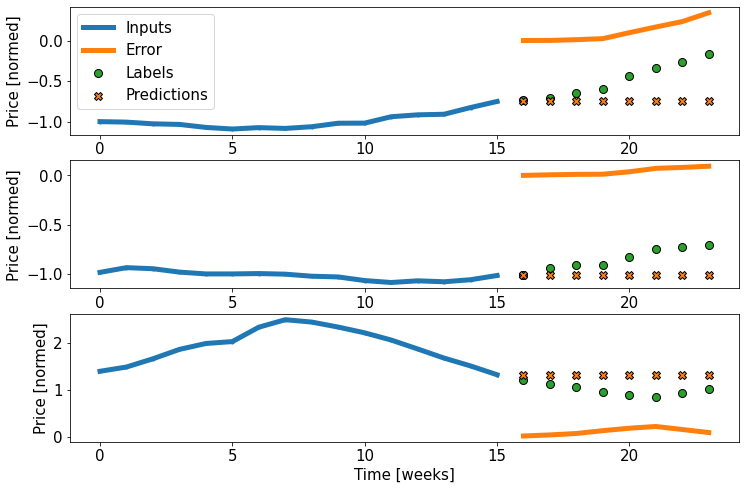

In [ ]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, Output_steps, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                      metrics=[tf.keras.metrics.MeanAbsoluteError()])


multi_val_performance['Last-Price Baseline'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last-Price Baseline'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

####***Model- IV Multi-time step Linear Model***
A simple linear model 


---



Epoch 1/30
264/264 [==============================] - 1s 2ms/step - loss: 0.2202 - mean_absolute_error: 0.3422 - val_loss: 0.5268 - val_mean_absolute_error: 0.5738
Epoch 2/30
264/264 [==============================] - 1s 2ms/step - loss: 0.1237 - mean_absolute_error: 0.2570 - val_loss: 0.4097 - val_mean_absolute_error: 0.5017
Epoch 3/30
264/264 [==============================] - 1s 2ms/step - loss: 0.1131 - mean_absolute_error: 0.2395 - val_loss: 0.3416 - val_mean_absolute_error: 0.4528
Epoch 4/30
264/264 [==============================] - 0s 2ms/step - loss: 0.1070 - mean_absolute_error: 0.2267 - val_loss: 0.2977 - val_mean_absolute_error: 0.4160
Epoch 5/30
264/264 [==============================] - 1s 2ms/step - loss: 0.1032 - mean_absolute_error: 0.2169 - val_loss: 0.2681 - val_mean_absolute_error: 0.3879
Epoch 6/30
264/264 [==============================] - 0s 2ms/step - loss: 0.1007 - mean_absolute_error: 0.2092 - val_loss: 0.2468 - val_mean_absolute_error: 0.3648
Epoch 7/30
264/2

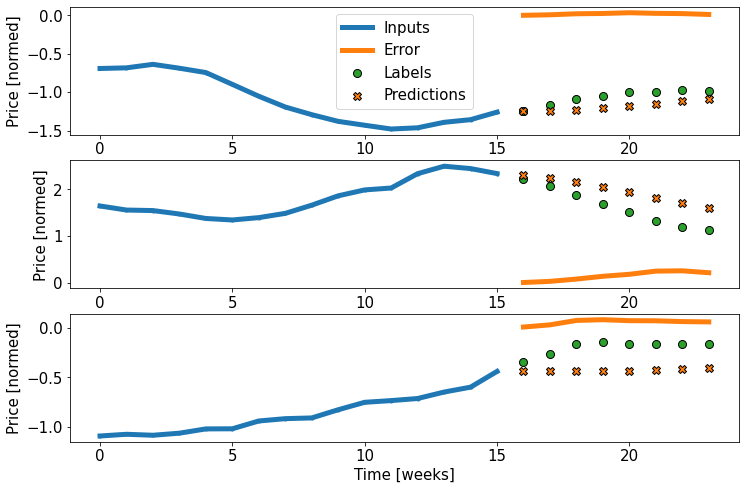

In [ ]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(Output_steps*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([Output_steps, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window, max_epochs = 30)

multi_val_performance['Linear Baseline'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear Baseline'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

####***Model- V Convolutional Model (Unoptimized)***
A shallow CNN model with a convolutional width of 3 (weeks)**bold text** 


---



Epoch 1/30
264/264 [==============================] - 1s 3ms/step - loss: 0.1319 - mean_absolute_error: 0.2451 - val_loss: 0.3362 - val_mean_absolute_error: 0.4421
Epoch 2/30
264/264 [==============================] - 1s 2ms/step - loss: 0.0885 - mean_absolute_error: 0.1938 - val_loss: 0.3037 - val_mean_absolute_error: 0.4092
Epoch 3/30
264/264 [==============================] - 1s 2ms/step - loss: 0.0849 - mean_absolute_error: 0.1886 - val_loss: 0.2967 - val_mean_absolute_error: 0.3993
Epoch 4/30
264/264 [==============================] - 1s 2ms/step - loss: 0.0819 - mean_absolute_error: 0.1832 - val_loss: 0.2973 - val_mean_absolute_error: 0.3999
Epoch 5/30
264/264 [==============================] - 1s 2ms/step - loss: 0.0809 - mean_absolute_error: 0.1822 - val_loss: 0.2862 - val_mean_absolute_error: 0.3876
Epoch 6/30
264/264 [==============================] - 1s 2ms/step - loss: 0.0794 - mean_absolute_error: 0.1786 - val_loss: 0.2961 - val_mean_absolute_error: 0.3950
Epoch 7/30
264/2

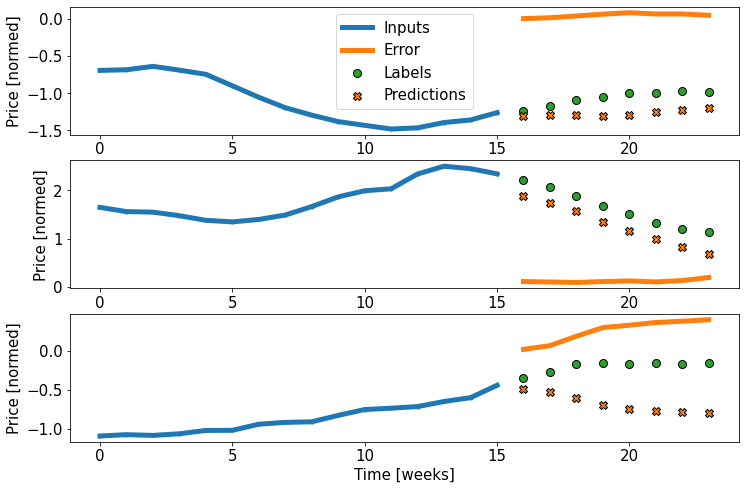

In [ ]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(Output_steps*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([Output_steps, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window,max_epochs =30)


multi_val_performance['Conv Neural Network'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv Neural Network'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

####Model- VI Convolutional Model (Optimized)


---



In [ ]:
def modular_convolutional_model(neurons,activation_f = 'relu', CONV_WIDTH=3):
  multi_conv_model = tf.keras.Sequential([
      # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
      tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
      # Shape => [batch, 1, conv_units]
      tf.keras.layers.Conv1D(neurons, activation= activation_f, kernel_size=(CONV_WIDTH)),
      # Shape => [batch, 1,  out_steps*features]
      tf.keras.layers.Dense(Output_steps*num_features,
                            kernel_initializer=tf.initializers.zeros()),
      # Shape => [batch, out_steps, features]
      tf.keras.layers.Reshape([Output_steps, num_features])
  ])
  return multi_conv_model

#####Hyperparameter Optimization (CAUTION: Do not run if time is a concern)
The activation functions and the number of input points contributing to the output are first optimized

In [ ]:
#CAUTION: Optimization step. Will take ~30mins
#Tracking performance through the cycling of hyperparameters in our quest to optimize 
number_of_neurons = [32,64,128]
activation_functions = ['tanh', 'sigmoid','relu']
conv_widths = [2,3,4,8]

parameter_results_cnn = []

for neuron in number_of_neurons:
  for activation_f in activation_functions:
    for CONV_WIDTH in conv_widths:
      print('Training model')
      print('Number of neurons: ' ,neuron, ' | Activation function employed: ',activation_f, ' | Conv width used: ',CONV_WIDTH)
      multi_conv_model = modular_convolutional_model(neuron,activation_f, CONV_WIDTH)
      wide_window2 = WindowGenerator(input_width=int(activation_results2[:,arrayIndex][0]),label_width=Output_steps,shift=Output_steps)
      history = compile_and_fit(multi_conv_model, wide_window2, max_epochs=50, patience=5, optimizer= tf.keras.optimizers.Adam())
      parameter_results_cnn.append(( neuron, activation_f,CONV_WIDTH, min(history.history['val_mean_absolute_error'])))


parameter_results_cnn2 = np.array(list(zip(*parameter_results_cnn)))
#min_val_loss3 = min(np.array(parameter_results_cnn2[3]))
#arrayIndex3 = parameter_results_cnn2[3].tolist().index(min_val_loss3)
#print('Minima : '+str(min_val_loss2))
#print('Optimum number of neurons : '+str(parameter_results_cnn2[:,arrayIndex][0])+ ' | Activation function suggested : '+str(parameter_results_cnn2[:,arrayIndex][1])+ ' | Conv width suggested : ' +str(parameter_results_cnn2[:,arrayIndex][2]))


In [ ]:
parameter_results_cnn2 = np.array(list(zip(*parameter_results_cnn)))
min_val_loss3 = min(np.array(parameter_results_cnn2[3]))
arrayIndex3 = parameter_results_cnn2[3].tolist().index(min_val_loss3)
print('Minima : '+str(min_val_loss2))
print('Optimum number of neurons : '+str(parameter_results_cnn2[:,arrayIndex][0])+ ' | Activation function suggested : '+str(parameter_results_cnn2[:,arrayIndex][1])+ ' | Conv width suggested : ' +str(parameter_results_cnn2[:,arrayIndex][2]))


Minima : 0.5457935333251953
Optimum number of neurons : 128 | Activation function suggested : relu | Conv width suggested : 8


Epoch 1/50
264/264 [==============================] - 1s 3ms/step - loss: 0.1832 - mean_absolute_error: 0.2999 - val_loss: 0.5566 - val_mean_absolute_error: 0.5829
Epoch 2/50
264/264 [==============================] - 1s 2ms/step - loss: 0.0958 - mean_absolute_error: 0.2102 - val_loss: 0.4509 - val_mean_absolute_error: 0.5149
Epoch 3/50
264/264 [==============================] - 1s 2ms/step - loss: 0.0893 - mean_absolute_error: 0.1967 - val_loss: 0.3899 - val_mean_absolute_error: 0.4746
Epoch 4/50
264/264 [==============================] - 1s 2ms/step - loss: 0.0849 - mean_absolute_error: 0.1896 - val_loss: 0.3645 - val_mean_absolute_error: 0.4535
Epoch 5/50
264/264 [==============================] - 1s 2ms/step - loss: 0.0828 - mean_absolute_error: 0.1880 - val_loss: 0.3408 - val_mean_absolute_error: 0.4336
Epoch 6/50
264/264 [==============================] - 1s 2ms/step - loss: 0.0805 - mean_absolute_error: 0.1837 - val_loss: 0.3139 - val_mean_absolute_error: 0.4180
Epoch 7/50
264/2

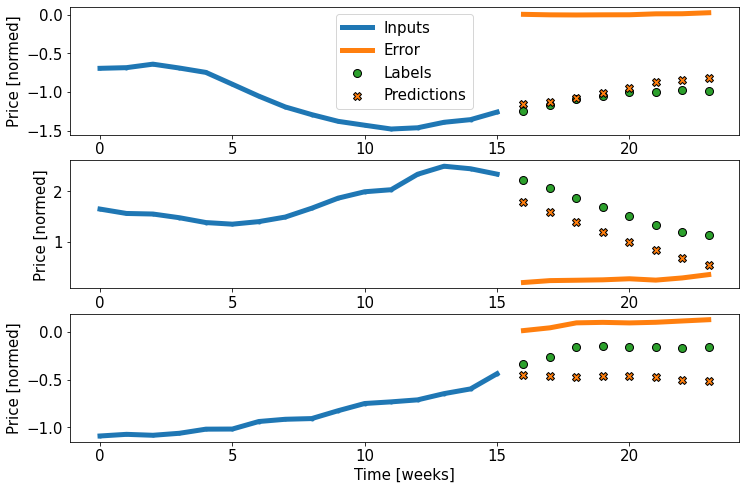

In [ ]:
#multi_conv_model_optimized = modular_convolutional_model(int(parameter_results_cnn2[:,arrayIndex][0]),parameter_results_cnn2[:,arrayIndex][1], int(parameter_results_cnn2[:,arrayIndex][2]))
multi_conv_model_optimized = modular_convolutional_model(128,'relu', 8)

history = compile_and_fit(multi_conv_model_optimized, multi_window, max_epochs=50, patience=5, optimizer= tf.keras.optimizers.Adam())
multi_val_performance['CNN optimized'] = multi_conv_model_optimized.evaluate(multi_window.val)
multi_performance['CNN optimized'] = multi_conv_model_optimized.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model_optimized)

####***Model- VII Dense Model (Unoptimized)***
Includes dense fully connected layer between input and output (~improved linear model)


---



Epoch 1/30
264/264 [==============================] - 1s 3ms/step - loss: 0.1245 - mean_absolute_error: 0.2356 - val_loss: 0.3297 - val_mean_absolute_error: 0.4357
Epoch 2/30
264/264 [==============================] - 1s 2ms/step - loss: 0.0890 - mean_absolute_error: 0.1900 - val_loss: 0.3149 - val_mean_absolute_error: 0.4077
Epoch 3/30
264/264 [==============================] - 1s 2ms/step - loss: 0.0864 - mean_absolute_error: 0.1857 - val_loss: 0.3197 - val_mean_absolute_error: 0.4068
Epoch 4/30
264/264 [==============================] - 1s 2ms/step - loss: 0.0849 - mean_absolute_error: 0.1842 - val_loss: 0.3171 - val_mean_absolute_error: 0.4010
Epoch 5/30
264/264 [==============================] - 1s 2ms/step - loss: 0.0830 - mean_absolute_error: 0.1806 - val_loss: 0.3332 - val_mean_absolute_error: 0.4037
Epoch 6/30
264/264 [==============================] - 1s 2ms/step - loss: 0.0817 - mean_absolute_error: 0.1787 - val_loss: 0.3363 - val_mean_absolute_error: 0.4081
Epoch 7/30
72/72

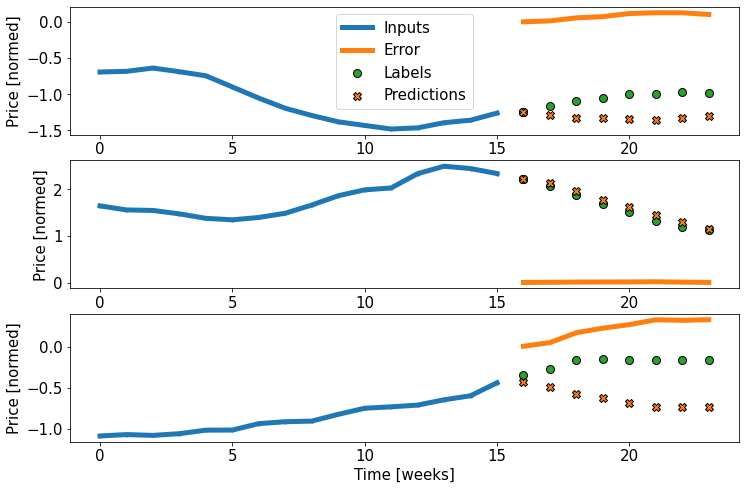

In [ ]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(Output_steps*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([Output_steps, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)


multi_val_performance['Dense Neural Network'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense Neural Network'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

##SECTION-V: Comparison of Models Explored
The performance of the forementioned six models are compared 

---



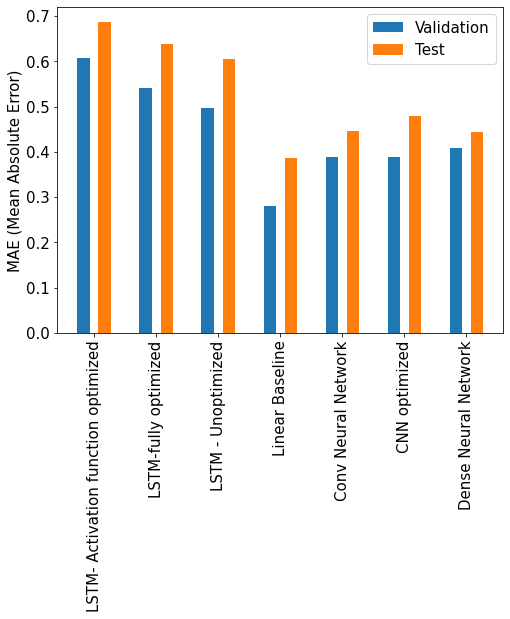

In [ ]:
performance_plotter (multi_performance, multi_val_performance, 1, width = 0.2)



---


Key takeaways:
Optimizing shallow models has not been very effective.

*   Features are heavily codependant reducing feature size to just CPI and Production 
*   Optimizing shallow models has not been very effective, require deep netwroks presented in Milestone_4_Part_II
*   Ideal candidates to explore deep architectures are Convolutional-NN and Dense-NN




---



